In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [3]:
num_skipped = 0
for folder_name in ("with_mask", "without_mask"):
    folder_path = os.path.join("data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
image_size = (180, 180)
batch_size = 36

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7471 files belonging to 2 classes.
Using 5977 files for training.
Using 1494 files for validation.


2024-09-08 21:40:05.691012: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-09-08 21:40:05.691038: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-09-08 21:40:05.691045: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-09-08 21:40:05.691059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-08 21:40:05.691070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-09-08 21:40:05.901790: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


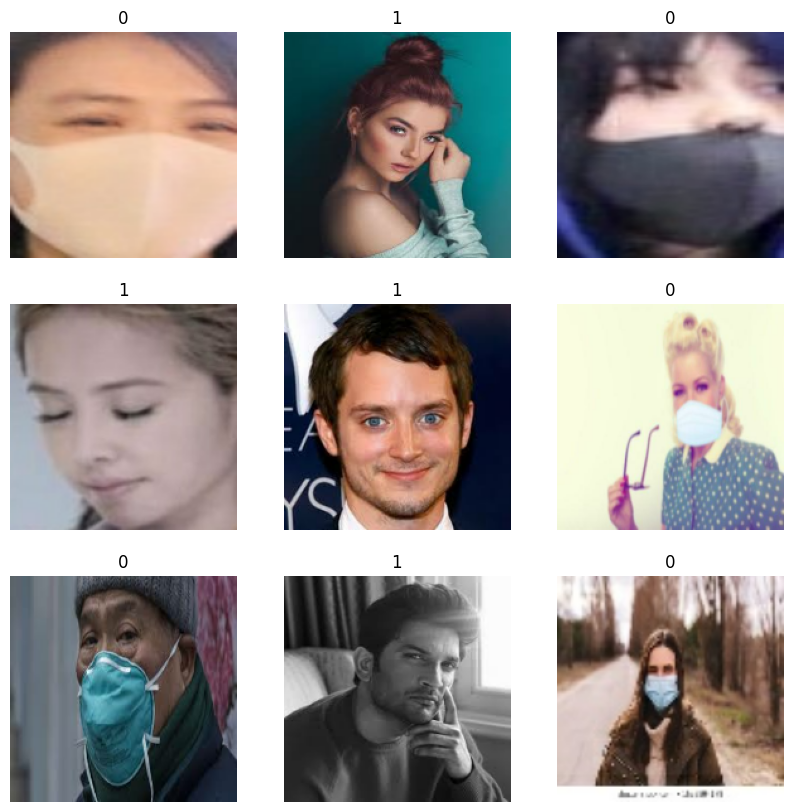

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [9]:
epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/25


2024-09-08 21:40:08.126492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


167/167 ━━━━━━━━━━━━━━━━━━━━ 68s 372ms/step - acc: 0.7778 - loss: 0.4522 - val_acc: 0.4880 - val_loss: 0.6975
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 366ms/step - acc: 0.9264 - loss: 0.1793 - val_acc: 0.4880 - val_loss: 0.6939
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 368ms/step - acc: 0.9476 - loss: 0.1233 - val_acc: 0.5850 - val_loss: 0.6377
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - acc: 0.9608 - loss: 0.0906 - val_acc: 0.9665 - val_loss: 0.1400
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 392ms/step - acc: 0.9729 - loss: 0.0707 - val_acc: 0.9438 - val_loss: 0.1093
Epoch 6/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 65s 391ms/step - acc: 0.9847 - loss: 0.0426 - val_acc: 0.9605 - val_loss: 0.0994
Epoch 7/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 394ms/step - acc: 0.9843 - loss: 0.0433 - val_acc: 0.9284 - val_loss: 0.2026
Epoch 8/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 395ms/step - acc: 0.9796 - loss: 0.0501 - val_acc: 0.9652 - val_loss: 0.1140
Epoch 9/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 67s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
This image is 0.08% with mask and 99.92% no mask.


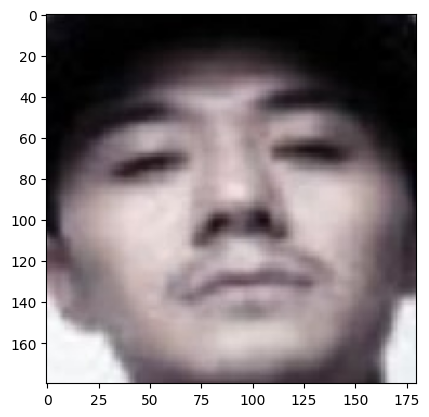

In [10]:
img = keras.utils.load_img("data/without_mask/without_mask_128.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(tf.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% with mask and {100 * score:.2f}% no mask.")

In [11]:
import sys
!{sys.executable} -m pip install scikit-learn==1.5.1

In [12]:
import sys
!{sys.executable} -m pip install scikeras

In [14]:
import keras
print(keras.__version__)

import sklearn
print(sklearn.__version__)

3.5.0
1.5.1


In [22]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [26]:
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
import numpy as np

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model=make_model(input_shape=image_size + (3,), num_classes=2)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

#

# Wrap the model in a KerasClassifier
model2 = KerasClassifier(model=model, epochs=10, batch_size=batch_size, verbose=1)

# Convert train_ds to numpy arrays (this is required for cross_val_score to work)
x_train, y_train = dataset_to_numpy(train_ds)

# Perform K-fold cross-validation using cross_val_score
from sklearn.model_selection import cross_val_score

# cross_val_score will handle the cross-validation process automatically
scores = cross_val_score(model2, x_train, y_train, cv=5)  # cv=5 for 5-fold cross-validation

# Output the scores
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {np.mean(scores)}")

/Users/tdewilde/JupyterProjects/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 57s 387ms/step - acc: 0.7570 - loss: 0.4648
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 359ms/step - acc: 0.9314 - loss: 0.1589
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - acc: 0.9563 - loss: 0.1140
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - acc: 0.9684 - loss: 0.0756
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - acc: 0.9734 - loss: 0.0665
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - acc: 0.9852 - loss: 0.0487
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - acc: 0.9890 - loss: 0.0327
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - acc: 0.9820 - loss: 0.0437
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - acc: 0.9949 - loss: 0.0191
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 48s 358ms/step - acc: 0.9954 - loss: 0.0161
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step


/Users/tdewilde/JupyterProjects/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 57s 361ms/step - acc: 0.7445 - loss: 0.4929
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 351ms/step - acc: 0.9222 - loss: 0.1816
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - acc: 0.9529 - loss: 0.1213
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - acc: 0.9643 - loss: 0.0886
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - acc: 0.9748 - loss: 0.0725
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - acc: 0.9847 - loss: 0.0480
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 351ms/step - acc: 0.9805 - loss: 0.0468
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 353ms/step - acc: 0.9863 - loss: 0.0405
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - acc: 0.9864 - loss: 0.0368
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - acc: 0.9933 - loss: 0.0195
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


/Users/tdewilde/JupyterProjects/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 57s 380ms/step - acc: 0.7813 - loss: 0.4577
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - acc: 0.9128 - loss: 0.1905
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - acc: 0.9571 - loss: 0.1108
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - acc: 0.9682 - loss: 0.0832
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - acc: 0.9723 - loss: 0.0691
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - acc: 0.9833 - loss: 0.0449
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - acc: 0.9881 - loss: 0.0349
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - acc: 0.9898 - loss: 0.0367
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - acc: 0.9891 - loss: 0.0311
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 367ms/step - acc: 0.9967 - loss: 0.0118
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


/Users/tdewilde/JupyterProjects/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 387ms/step - acc: 0.7684 - loss: 0.4865
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - acc: 0.9199 - loss: 0.1943
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - acc: 0.9504 - loss: 0.1232
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - acc: 0.9711 - loss: 0.0776
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - acc: 0.9743 - loss: 0.0695
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step - acc: 0.9860 - loss: 0.0375
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 372ms/step - acc: 0.9811 - loss: 0.0537
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - acc: 0.9881 - loss: 0.0303
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step - acc: 0.9915 - loss: 0.0287
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 370ms/step - acc: 0.9920 - loss: 0.0243
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


/Users/tdewilde/JupyterProjects/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 61s 402ms/step - acc: 0.7772 - loss: 0.4567
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - acc: 0.9181 - loss: 0.1973
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 378ms/step - acc: 0.9549 - loss: 0.1132
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - acc: 0.9663 - loss: 0.0882
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 51s 382ms/step - acc: 0.9790 - loss: 0.0551
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 51s 381ms/step - acc: 0.9815 - loss: 0.0481
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - acc: 0.9841 - loss: 0.0389
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - acc: 0.9892 - loss: 0.0286
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - acc: 0.9957 - loss: 0.0147
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 50s 378ms/step - acc: 0.9944 - loss: 0.0194
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step
Cross-validation scores: [0.9673913  0.81521739 0.96569038 0.98410042 0.9790795 ]
Average cross-validation score: 0.942